# Autoregressive (AR) HMM Demo

This notebook demonstrates how to construct and fit a linear autoregressive HMM.
Let $y_t$ denote the observation at time $t$. Let $z_t$ denote the corresponding discrete latent state.

The autoregressive hidden Markov model has the following likelihood,

\begin{align*}
y_t \mid y_{t-1}, z_t &\sim
\mathcal{N}\left(A_{z_t} y_{t-1} + b_{z_t}, Q_{z_t} \right).
\end{align*}

(Higher-order autoregressive processes are also supported.) 

This notebook will also show how inputs are passed into SSMs in Dynamax.

## Setup

In [1]:
from scipy import io
from pathlib import Path
import numpy as np
import matplotlib.patches as mpatches

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

### Helper functions for plotting

In [3]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [4]:
def plot_emissions_and_states(emissions, most_likely_states, posterior, cmap, colors):
    
    plot_slice = (0, 300)
    emission_dim = emissions.shape[-1]
    time_bins = emissions.shape[0]
    state_probability_spread = posterior.smoothed_probs.T
    # lim = 1.1 * abs(emissions).max()
    lim = 1

    plt.figure(figsize=(8, 6))
    plt.suptitle("Emissions and Inferred States", y=1.01)

    # Plot number 1
    plt.subplot(211)

    im = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors)-1,
        extent=(0, time_bins, -lim, (emission_dim)*lim)
    )

    values = np.unique(most_likely_states.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="State {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Most Likely Z")

    # emissions line
    for d in range(emission_dim):
        plt.plot(emissions[:,d] + lim * d, '-k')

    plt.xlim(plot_slice)
    plt.yticks([+1, 0, -1])


    # Plot number 2
    plt.subplot(212)
    plt.imshow(state_probability_spread, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(plot_slice)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks(ticks=range(state_probability_spread.shape[0]), labels=range(state_probability_spread.shape[0]))
    plt.xlabel("time")

    plt.show()

## RNN DATA

In [5]:
rnn_dirs = sorted(Path("../rnns/").iterdir())

def load_rnn(rnn_dirs, rnn_num):
    trial = io.loadmat(rnn_dirs[rnn_num * 2 - 1])
    return trial['test_out']

In [6]:
choices = load_rnn(rnn_dirs, 1)

observations = choices.reshape(-1, 300)[60]
# choices_binarized
# model_choices = (choices[:,:,-50:].mean(axis=2) > 0.5).astype(int).reshape(1,-1,1) 
# model_choices.shape

In [7]:
choices.shape, observations.shape

((4, 50, 300), (300,))

## Manually construct an ARHMM

In [8]:
emissions = observations.reshape(-1, 1)

inputs = np.zeros((emissions.shape[0], 1))
inputs[1:] = emissions[:-1]

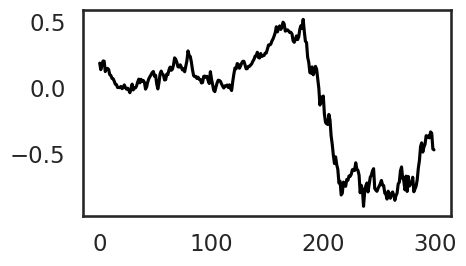

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(emissions[:,0], '-k')
plt.tight_layout()


## Fit an ARHMM

In [10]:
num_states = 4
num_lags = 1
emission_dim = 1

# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

In [11]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

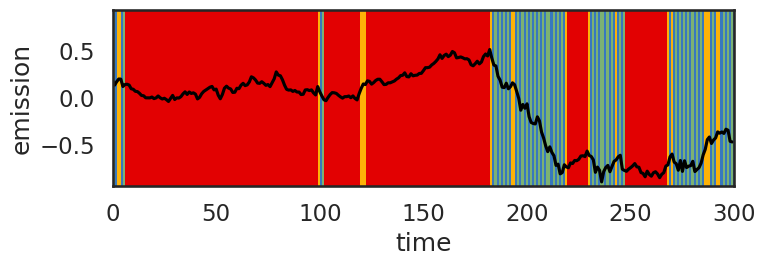

In [12]:
plot_slice = (0, 300)
time_bins = 300
lim = 1.05 * abs(emissions).max()
plt.figure(figsize=(8, 3))

plt.imshow(most_likely_states[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (emission_dim)*lim))

for d in range(emission_dim):
    plt.plot(emissions[:,d] + lim * d, '-k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.ylabel("emission")
plt.tight_layout()

### Plot the log likelihoods against the true likelihood, for comparison

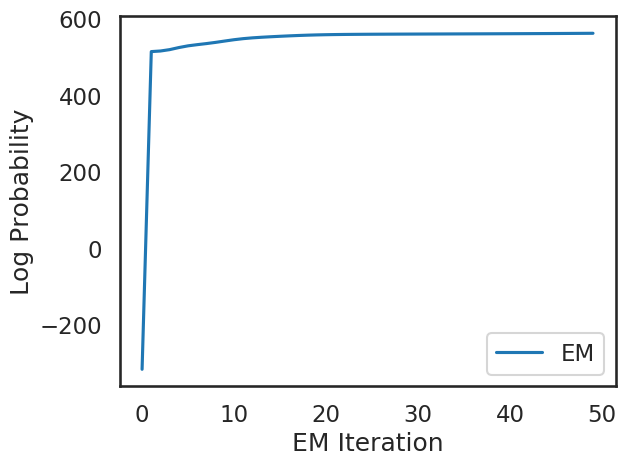

In [13]:
# true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
# plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

### Find the most likely states


In [14]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

In [15]:
posterior.smoothed_probs.T.shape, most_likely_states.shape

((4, 300), (300,))

### Plot the true and inferred discrete states

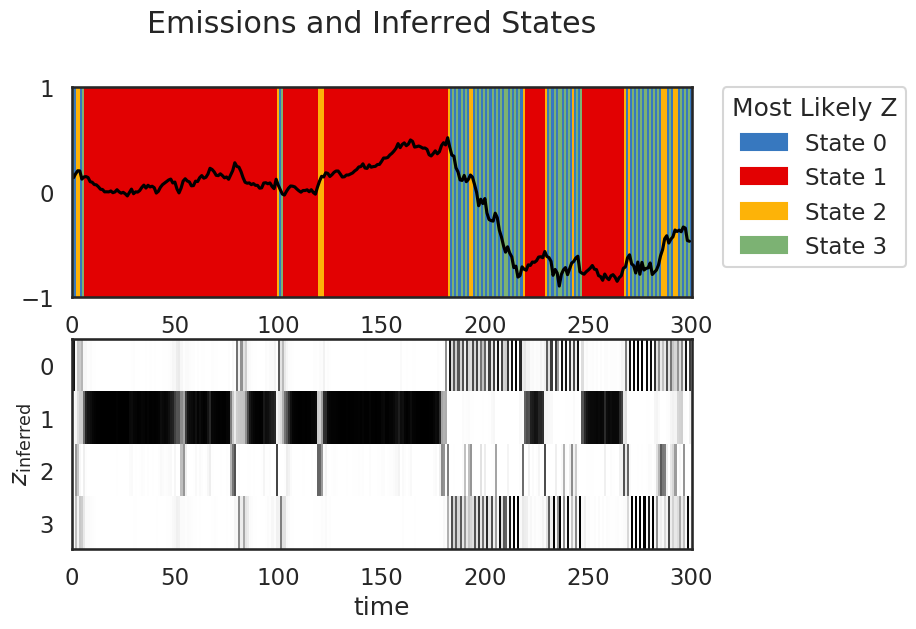

In [16]:
plot_emissions_and_states(emissions, most_likely_states, posterior, cmap, colors)